<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/Multivariate_LSTM_(Multisalida)_ajusco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


def train_multivariate_lstm(file_path, target_station="AJUSCO", window_size=30,
                            epochs=20, batch_size=32, multisalida=True):
    """
    Entrena un LSTM multivariado para pronóstico de lluvia.

    Parámetros
    ----------
    file_path : str
        Ruta del CSV con datos de lluvia.
    target_station : str
        Nombre de la estación a predecir (si multisalida=False).
    window_size : int
        Número de días pasados a usar como entrada.
    epochs : int
        Número de épocas de entrenamiento.
    batch_size : int
        Tamaño de batch.
    multisalida : bool
        - True: predice todas las estaciones simultáneamente.
        - False: predice solo la estación target_station.
    """

    # ---------------------------
    # 1. Load Data
    # ---------------------------
    df = pd.read_csv(file_path)

    # ---------------------------
    # 2. Handle Missing Values
    # ---------------------------
    df = df.interpolate(method="linear", limit_direction="forward", axis=0).fillna(0)

    # Extraer estaciones (sin la columna de fecha)
    data = df.drop(columns=["Unnamed: 0"]).values
    stations = df.drop(columns=["Unnamed: 0"]).columns.tolist()

    # Normalización
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Índice de estación objetivo
    target_idx = stations.index(target_station)

    # ---------------------------
    # 3. Create Sequences
    # ---------------------------
    X, y = [], []
    for i in range(len(data_scaled) - window_size):
        X.append(data_scaled[i:i+window_size])

        if multisalida:
            y.append(data_scaled[i+window_size])   # todas las estaciones
        else:
            y.append(data_scaled[i+window_size, target_idx])  # solo target

    X = np.array(X)
    y = np.array(y)

    if not multisalida:
        y = y.reshape(-1, 1)

    print(f"Input shape: {X.shape}, Output shape: {y.shape}")

    # ---------------------------
    # 4. Split Train/Test
    # ---------------------------
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------------------------
    # 5. Build LSTM Model
    # ---------------------------
    output_dim = X.shape[2] if multisalida else 1

    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=False, input_shape=(window_size, X.shape[2])),
        Dense(output_dim)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # ---------------------------
    # 6. Train Model
    # ---------------------------
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, verbose=1)

    # ---------------------------
    # 7. Evaluate Model
    # ---------------------------
    loss = model.evaluate(X_test, y_test)
    print(f"Test MSE: {loss:.4f}")

    # ---------------------------
    # 8. Make Predictions
    # ---------------------------
    predictions = model.predict(X_test)

    if multisalida:
        # Invertir normalización para todas las estaciones
        predictions_rescaled = scaler.inverse_transform(predictions)
        y_test_rescaled = scaler.inverse_transform(y_test)
    else:
        # Crear matriz temporal con ceros para invertir normalización de target
        temp_pred = np.zeros((len(predictions), len(stations)))
        temp_pred[:, target_idx] = predictions[:, 0]
        predictions_rescaled = scaler.inverse_transform(temp_pred)[:, target_idx]

        temp_test = np.zeros((len(y_test), len(stations)))
        temp_test[:, target_idx] = y_test[:, 0]
        y_test_rescaled = scaler.inverse_transform(temp_test)[:, target_idx]

    # ---------------------------
    # 9. Plot Results
    # ---------------------------
    plt.figure(figsize=(12, 5))
    if multisalida:
        plt.plot(y_test_rescaled[:, target_idx], label=f"Actual {target_station}")
        plt.plot(predictions_rescaled[:, target_idx], label=f"Predicted {target_station}")
        plt.title(f"Multivariate LSTM (Multisalida) - Station: {target_station.upper()}")
    else:
        plt.plot(y_test_rescaled, label=f"Actual {target_station}")
        plt.plot(predictions_rescaled, label=f"Predicted {target_station}")
        plt.title(f"Multivariate LSTM (Unisalida) - Station: {target_station.upper()}")

    plt.legend()
    plt.xlabel("Days (Test Set)")
    plt.ylabel("Rainfall (mm)")
    plt.show()

    return model, history


/tmp/ipython-input-508226201.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear", limit_direction="forward", axis=0).fillna(0)


Input shape: (1431, 30, 652), Output shape: (1431, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       399,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,001 (1.53 MB)

 Trainable params: 400,001 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0461 - val_loss: 0.0021
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0109 - val_loss: 0.0041
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0071 - val_loss: 0.0165
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0030 - val_loss: 0.0143
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0

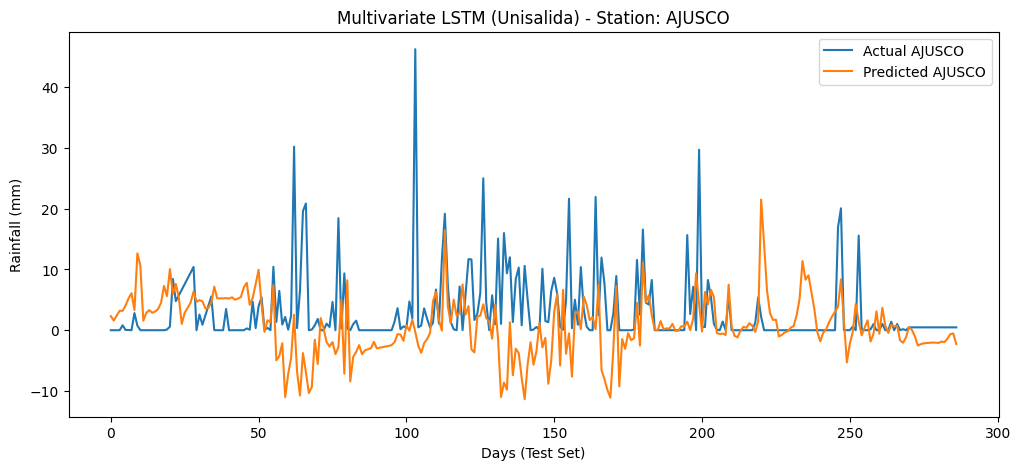

In [5]:
model, history = train_multivariate_lstm(
    file_path="data/All_rain_Valle_bien.csv",
    target_station="AJUSCO",
    multisalida=False
)


/tmp/ipython-input-508226201.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear", limit_direction="forward", axis=0).fillna(0)


Input shape: (1431, 30, 652), Output shape: (1431, 652)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       399,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 652)            │        84,108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,980 (1.85 MB)

 Trainable params: 483,980 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0148 - val_loss: 0.0094
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0

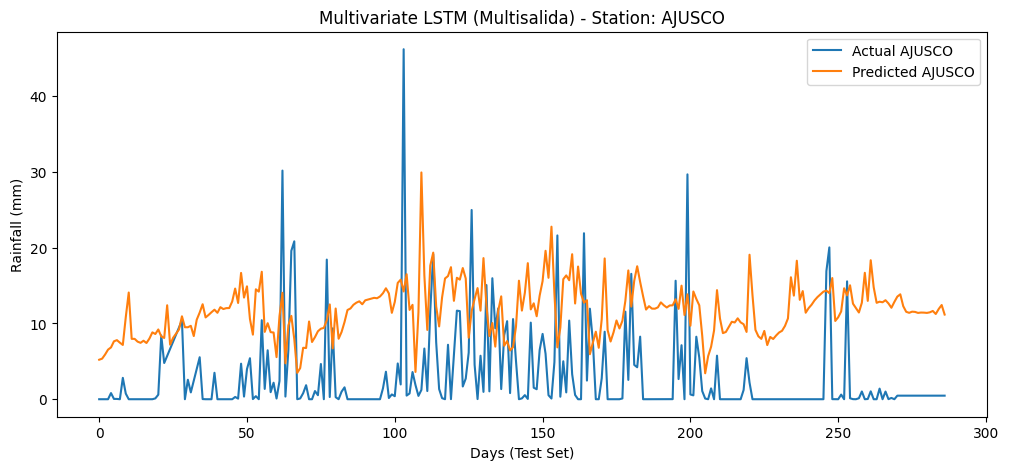

In [6]:
model, history = train_multivariate_lstm(
    file_path="data/All_rain_Valle_bien.csv",
    target_station="AJUSCO",  # solo para graficar
    multisalida=True
)
